In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch

from data import generate_data, rot
from dense import pack_dense
from distributions import NormalInverseWishart, MatrixNormalInverseWishart
from distributions.gaussian import natural_to_info
from global_param import initialize_global_lds_parameters, natural_gradient, gradient_descent
from lds import (
    info_observation_params,
    info_kalman_filter,
    info_kalman_smoothing,
    info_sample_backward,
    sample_forward_messages,
    sample_backward_messages,
)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=np.VisibleDeprecationWarning)

In [2]:
# size parameters
N = 2
T = 900

A = 0.999 * rot(torch.tensor(2 * torch.pi / 30))
Q = 0.1 * torch.eye(N)
C = torch.eye(N)
R = 0.0001 * torch.eye(N)

latents, obs = generate_data(A, Q, C, R, 100)

obs = obs.unsqueeze(1)

niw_prior, mniw_prior = initialize_global_lds_parameters(N)
niw_param, mniw_param = initialize_global_lds_parameters(N)

mniw_prior, mniw_param = list(mniw_prior), list(mniw_param)

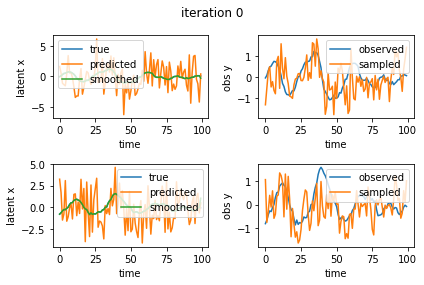

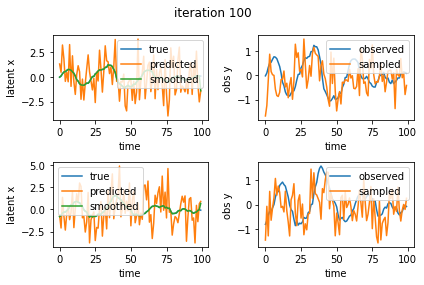

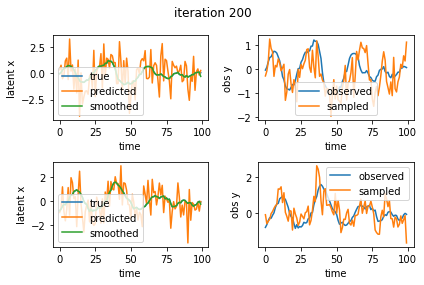

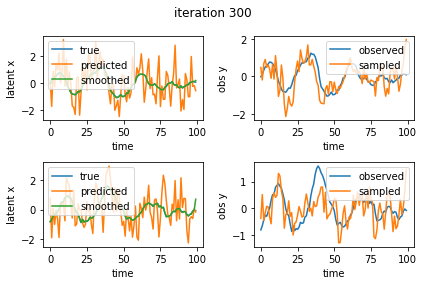

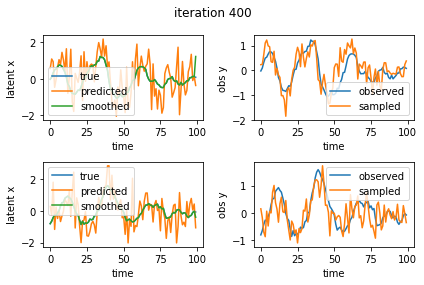

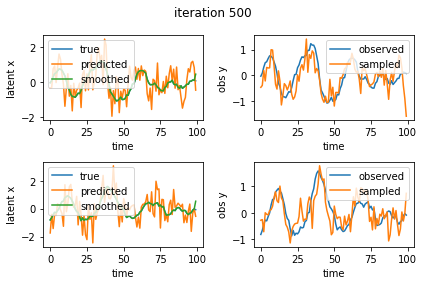

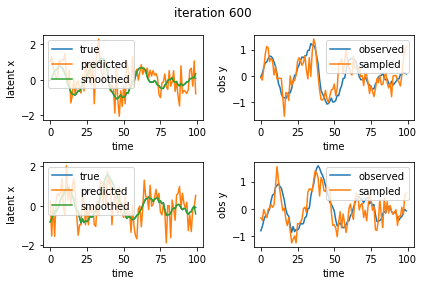

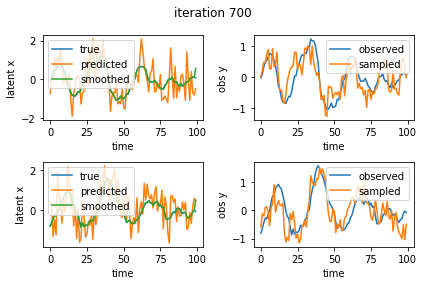

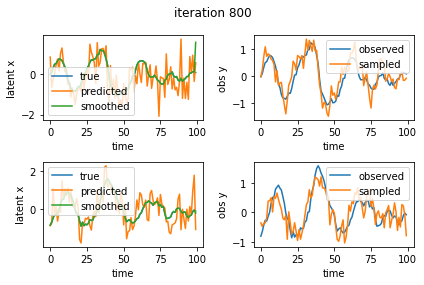

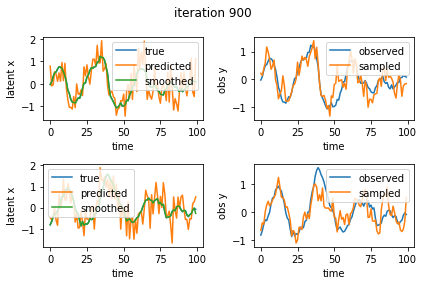

In [3]:
# optimize prior
n_iter = 1000
for i in range(n_iter):
    # J11, J12, J22 = info_pair_params(A, Q)
    J22, J12, J11, _ = MatrixNormalInverseWishart(mniw_param).expected_stats()
    J11 *= -2
    J12 *= -1
    J22 *= -2

    y = info_observation_params(obs, C, R)

    # init_params = (torch.inverse(Q), torch.zeros(1))
    init_params = natural_to_info(NormalInverseWishart(niw_param).expected_stats())

    forward_messages = info_kalman_filter(
        init_params=init_params, pair_params=(J11, J12, J22), observations=y
    )
    backward_messages, expected_stats = info_kalman_smoothing(
        forward_messages, pair_params=(J11, J12, J22)
    )
    E_init_stats, E_pair_stats, _ = expected_stats

    forward_samples = sample_forward_messages(forward_messages)
    backward_samples = sample_backward_messages(backward_messages)
    samples = info_sample_backward(forward_messages, pair_params=(J11, J12, J22))

    # plot
    if i % max((n_iter // 10), 1) == 0 or i == 0:
        fig, ax = plt.subplots(N, 2)

        for n in range(N):
            ax1 = ax[n, 0]
            ax1.plot(latents.detach().numpy()[:, n], label="true")
            ax1.plot(forward_samples[:, n], label="predicted")
            ax1.plot(backward_samples[:, n], label="smoothed")
            ax1.legend()
            ax1.set_xlabel("time")
            ax1.set_ylabel("latent x")

            ax2 = ax[n, 1]
            ax2.plot(obs.squeeze().detach().numpy()[:, n], label="observed")
            ax2.plot(samples.squeeze().detach().numpy()[:, n], label="sampled")
            ax2.legend()
            ax2.set_xlabel("time")
            ax2.set_ylabel("obs y")

        plt.suptitle(f"iteration {i}")
        plt.tight_layout()
        plt.show()

    # update global param
    nat_grad_init = natural_gradient(
        pack_dense(*E_init_stats), niw_param, niw_prior, len(obs), 1
    )
    niw_param = gradient_descent(
        niw_param, torch.stack(nat_grad_init), step_size=1e-1
    )

    nat_grad_pair = natural_gradient(
        E_pair_stats, mniw_param, mniw_prior, len(obs), 1
    )
    mniw_param = gradient_descent(mniw_param, nat_grad_pair, step_size=1e-2)